# Hillslope Discharge Tutorial

This notebook outlines how to access parameters and forcing data across a collection of REWs in order to compute hillslope discharge. We pay special attention to dealing with REW parameter and climate groups, which potentially simplify calibration procedures. In this example, we lay out the general organization to deal with multiple parameter groups but will in fact only consider one.  

In [1]:
%matplotlib inline
import os
from matplotlib import pylab
import sys
from os.path import dirname
parent_dir = dirname(dirname(os.getcwd()))
sys.path.append(os.path.join(parent_dir,'StreamflowTempModel','2_hillslope_discharge'))
sys.path.append(os.path.join(parent_dir,'StreamflowTempModel','1_data_preparation'))
sys.path.append(os.path.join(parent_dir,'StreamflowTempModel','3_channel_routing'))

from vadoseZone import *
from groundwaterZone import *
from REW import REW
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
import pickle
from datetime import date
import pandas as pd
import numpy as np
import time
import sys

from prep import rew_params
rew_params()

First, we'll need to set up some data structures to hold parameters and forcing data. We'll assume that these have already been computed and have been stored in the `model_data` subfolder of the parent folder. For information on the creation of these data, refer to the [model parameterization](./parameterize_and_configure.ipynb) or [data preparation](./prism_forcing.ipynb) notebooks. 

The `rew_config` dictionary has as its keys the list of all REWs to be modeled in the simulation. The value of each key contains data primarily related to physical topological attributes of each REW. The most important fields in this example will be `climate_group`, `parameter_group`, and `group`, which specify the parameter set and forcing data required to run the model for each REW. 

The `parameter_group_params` dictionary has as its keys the list of all REW parameter groups. For each group, we can specify both scalars, like a soil moisture field capacity, and classes, like specific groundwater and vadose zone models. **The parameters enumerated for each parameter group must include those needed to fully populate the chosen vadose zone and groundwater zone models, and the naming conventions between `parameter_group_params` and each class must match.** For instance, if the chosen vadose zone model has a field capacity attribute named `sfc`, then each value in the `parameter_group_params` dictionary must have a `sfc` key. Combining parameter groups with climate groups allows us perform expensive calibration procedures on a potentially small number of REW "types" (e.g., coastal belt covered in a Douglas fir, with particular climate data), rather than on each REW individually. 

The `model_config` dictionary contains the high level parameters needed to spool up and execute the time domain simulation. Values include time stamps at which hillslope discharge will be computed, as well as the time step lengths and resampling frequencies necessary to map forcing data onto the desired simulation timescales. 

In [2]:
# Load config, parameter, and forcing files

parent_dir = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(os.path.join(parent_dir, 'StreamflowTempModel', '1_data_preparation'))
rew_config = pickle.load( open( os.path.join(parent_dir,'model_data','rew_config.p'), "rb" ) )
climate_group_forcing = pickle.load( open( os.path.join(parent_dir,'model_data','climate_group_forcing.p'), "rb" ) )
parameter_group_params = pickle.load( open( os.path.join(parent_dir,'model_data','parameter_group_params.p'), "rb" ))
model_config = pickle.load( open( os.path.join(parent_dir, 'model_data', 'model_config.p'), 'rb'))


Before starting the simulation, it's convenient to load some of the model configuration data into the local workspace, rather than continually pulling from the `model_config` dictionary. 

The most important quantities here are the `start_date`, `stop_date` and `spinup_date`. The first two are self-explanatory; the last specifies the date at which we assume transients related, for instance, to starting with empty groundwater and vadose zone stocks have exited the system. 

Note that `model_config` typically contains datetime indices, time steps, and resampling frequencies related to both the hillslope dischage _and_ channel routing models. Since we'll only be dealing with the hillslope part of the process in this example, we'll simplify the notation. 

In [3]:
start_date = model_config['start_date']
stop_date = model_config['stop_date']
spinup_date = model_config['spinup_date']
Tmax = model_config['Tmax']
dt = 1/4.
resample_freq_hillslope = str(int(dt*24*60)) + 'T'
#resample_freq_hillslope = model_config['resample_freq_hillslope']
Tmax = model_config['Tmax']
timestamps_hillslope = pd.date_range(start_date, stop_date, freq=resample_freq_hillslope)
t = np.linspace(0,Tmax,np.ceil(Tmax/dt)+1)

# define a downsampler that conserves integrated mass
def intMean(array_like):
    if len(array_like)==1:
        return np.mean(array_like)
    else:
        dt = float((array_like.index[1] - array_like.index[0]).seconds)/86400.0 # get timestep in days
        return np.trapz(array_like, dx=dt)+dt*array_like.ix[-1]

With the forcing data, REW parameterizations, and overarching model description in hand, we're finally ready to run the model. We assume that in terms of hillslope discharge, no REW depends on any other, and so we can simply simulate discharge sequentially along the list of REW groups. For each REW group, we

* Instantiate a `REW` instance using the parameterization provided in `parameter_group_params`. For each REW group, the appropriate parameter group ID is located in `rew_config[REW ID]['parameter_group']`;
* Intialize empty vadose zone and groundwater zone stocks, as well as empty time series related to the major fluxes of each zone;
* Populate the attributes of both the vadose and groundwater zones. At REW instantiation, both the vadose zone and groundwater zone are empty. Therefore, the `parameter_group_params` dictionary **must** specify all quantities necessary for model execution, and these quantities must have the same variable name in both `parameter_group_params` and the corresponding model class; 
* Resample forcing data at the hillslope discharge simulation timescale, which is specified in `model_config`; The forcing data corresponds to the climate group forcing data associated with the overarching REW group. 
* Simulate hillslope discharge at each time specified in the `t_hillsope` field of `model_config`;
* Store the flux and stock time series data in a Pandas data frame for each REW group, and bundle these Pandas data frames into a dictionary of solved hillslopes indexed by its group ID;
* Save these solved hillslopes to the pickle file `solved_group_hillslopes` in the `model_data folder`.

In [4]:
group_ids = list(set([rew_config[i]['group'] for i in rew_config.keys()]))
solved_group_hillslopes_dict = {}

for group_id in group_ids:

    parameter_group_id = group_id[0]
    climate_group_id = group_id[1]
        
    vz = parameter_group_params[parameter_group_id]['vz'](**parameter_group_params[parameter_group_id])
    gz = parameter_group_params[parameter_group_id]['gz'](**parameter_group_params[parameter_group_id])    
    
    rew = REW(vz, gz,  **{'pet':climate_group_forcing[climate_group_id].pet, 'ppt':climate_group_forcing[climate_group_id].ppt, 'aspect':90})

    storageVZ       = np.zeros(np.size(t))
    storageGZ       = np.zeros(np.size(t))
    discharge       = np.zeros(np.size(t))
    leakage         = np.zeros(np.size(t))
    ET              = np.zeros(np.size(t))
    ETR              = np.zeros(np.size(t))
    ETS              = np.zeros(np.size(t))
    overlandFlow    = np.zeros(np.size(t))
    
    # Resample pet and ppt to integration timestep
    ppt = np.array(rew.ppt[start_date:stop_date].resample(resample_freq_hillslope).ffill())
    pet = np.array(rew.pet[start_date:stop_date].resample(resample_freq_hillslope).ffill())

    # Solve group hillslope
    for i in range(len(t)):
        rew.vz.update(dt,**{'ppt':ppt[i],'pet':pet[i]})
        storageVZ[i]    = rew.vz.storageVZ
        leakage[i]      = rew.vz.leakage
        ET[i]           = rew.vz.ET
        rew.gz.update(dt,**{'leakage':leakage[i]})
        storageGZ[i] = rew.gz.storageGZ
        discharge[i] = rew.gz.discharge
        overlandFlow[i] = rew.vz.overlandFlow + rew.gz.overlandFlow
        try: 
            ETR[i] = rew.vz.ETR
            ETS[i] = rew.vz.ETS
        except:
            continue
    
    
    # Save all results as daily data. 
    solved_hillslope = pd.DataFrame({'storageGZ':storageGZ, 'leakage':leakage, 'ET':ET, 'storageVZ':storageVZ, 'discharge':discharge, 'overlandFlow':overlandFlow, 'ETR':ETR, 'ETS':ETS, 'ppt':ppt}, index=timestamps_hillslope)
    
    stores = ['storageGZ','storageVZ']
    df = pd.DataFrame()
    for col in solved_hillslope.columns:
        if col in stores:
            print(col)
            df[col] = solved_hillslope[col].resample('D').first()
        else:
            df[col] = solved_hillslope[col].resample('D').mean()
            
    solved_group_hillslopes_dict[group_id] = df
    
print(solved_group_hillslopes_dict[group_id].head())

storageGZ
storageVZ
             ET  ETR  ETS  discharge  leakage  overlandFlow  ppt  storageGZ  \
2012-07-01  0.0  0.0  0.0   0.298840      0.0           0.0  0.0   1.895924   
2012-07-02  0.0  0.0  0.0   0.112640      0.0           0.0  0.0   1.662139   
2012-07-03  0.0  0.0  0.0   0.043745      0.0           0.0  0.0   1.573563   
2012-07-04  0.0  0.0  0.0   0.018234      0.0           0.0  0.0   1.538727   
2012-07-05  0.0  0.0  0.0   0.008780      0.0           0.0  0.0   1.523793   

            storageVZ  
2012-07-01        0.0  
2012-07-02        0.0  
2012-07-03        0.0  
2012-07-04        0.0  
2012-07-05        0.0  


(0, 2)

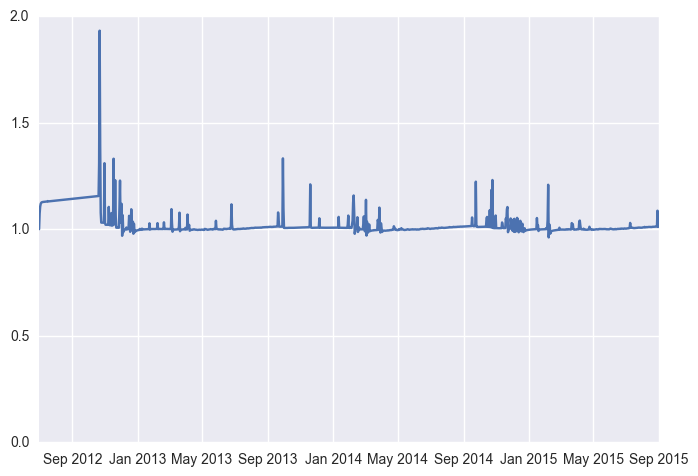

In [5]:
df = solved_group_hillslopes_dict[(1,0)]; dtt = 1
# df = solved_hillslope; dtt = dt

cumPpt = np.cumsum(df.ppt)*dtt
cumDis = np.cumsum(df.discharge)*dtt
cumET = np.cumsum(df.ET)*dtt

S0 = df.storageGZ[0] + df.storageVZ[0] + cumET[0] + cumDis[0] - cumPpt[0]
totalIn = cumPpt
S = df.storageGZ + df.storageVZ
totalOut = cumET + cumDis
balance = (totalIn - totalOut + S0)/S

#should be 1 at all times
plt.plot(balance)
plt.ylim((0,2))

In [6]:
dt

0.25

In [7]:
    solved_group_hillslopes_dict.keys()

[(1, 0)]

In [8]:
solved_group_hillslopes_dict[(1,0)].storageGZ[1] - solved_group_hillslopes_dict[(1,0)].storageGZ[0]


-0.23378467374265899

In [9]:
x = solved_hillslope.discharge
y = solved_hillslope.storageGZ

sum(x[0:4])/4
x[0:4]

2012-07-01 00:00:00    0.416305
2012-07-01 06:00:00    0.325377
2012-07-01 12:00:00    0.254481
2012-07-01 18:00:00    0.199197
Freq: 360T, Name: discharge, dtype: float64

In [10]:
x.resample('D')

/Users/nathankarst/anaconda/envs/py2k_model/lib/python2.7/site-packages/IPython/utils/dir2.py:65: FutureWarning: .resample() is now a deferred operation
use .resample(...).mean() instead of .resample(...)
  canary = getattr(obj, '_ipython_canary_method_should_not_exist_', None)
/Users/nathankarst/anaconda/envs/py2k_model/lib/python2.7/site-packages/IPython/utils/dir2.py:74: FutureWarning: .resample() is now a deferred operation
use .resample(...).mean() instead of .resample(...)
  m = getattr(obj, name, None)


DatetimeIndexResampler [freq=<Day>, axis=0, closed=left, label=left, convention=start, base=0]

In [11]:
0.221902*.25

0.0554755

In [12]:
df

,ET,ETR,ETS,discharge,leakage,overlandFlow,ppt,storageGZ,storageVZ
2012-07-01,0.000000,0.000000,0.000000,0.298840,0.0,0.0,0.0000,1.895924,0.000000
2012-07-02,0.000000,0.000000,0.000000,0.112640,0.0,0.0,0.0000,1.662139,0.000000
2012-07-03,0.000000,0.000000,0.000000,0.043745,0.0,0.0,0.0000,1.573563,0.000000
2012-07-04,0.000000,0.000000,0.000000,0.018234,0.0,0.0,0.0000,1.538727,0.000000
2012-07-05,0.000000,0.000000,0.000000,0.008780,0.0,0.0,0.0000,1.523793,0.000000
2012-07-06,0.000000,0.000000,0.000000,0.005271,0.0,0.0,0.0000,1.516237,0.000000
2012-07-07,0.000000,0.000000,0.000000,0.003962,0.0,0.0,0.0000,1.511422,0.000000
2012-07-08,0.000000,0.000000,0.000000,0.003468,0.0,0.0,0.0000,1.507631,0.000000
2012-07-09,0.000000,0.000000,0.000000,0.003276,0.0,0.0,0.0000,1.504228,0.000000
2012-07-10,0.000000,0.000000,0.000000,0.003196,0.0,0.0,0.0000,1.500979,0.000000
